# 4 Filtering a normalized expression matrix TPM

Made by: Cynthia Soto <br>
Date: March 19th 2021 <br>
Last md: April 19th 2021 <br>

Filter TPMs atipical values  <br>

**Assumptions:**<br>
1. Matrix expression is in TPMs
2. Filter data ousite a specific range

In [1]:
# Libraries required
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [2]:
#  @dir_to_parse        Set the folder to be parse (the raw count must to be there)
#  @general_titles      This var is used to label the plots and save the temporary files. 

###   Here, I am choosing what dataset I am going to process
#general_titles="healthy"
general_titles="infected"

try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")        

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


Notes:
   1. TPM considers the gene length for normalization
   2. TPM is suitable for sequencing protocols where reads sequencing depends on gene length <br>
More details about normalization: https://www.reneshbedre.com/blog/expression_units.html <br>
If you want to better understand why normalize and filter data before any advance analysis, here a post of Jason W Hoskins about **Warnings against using unnormalized, unfiltered read counts for a few reasons** https://www.researchgate.net/post/What-is-a-valid-way-to-measure-variability-of-gene-expression-from-gtex-data <br><br>

Eg. If the TPM for gene A in sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number.

### Declare functions

In [3]:
#  Plot the distributions: values are raw data - not normalized 

def df_KDE(df_p, samples, main_t, x_label):
    plt.style.use('seaborn-whitegrid')
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})

    plt.figure(figsize=(10,7), dpi= 80)
    for file in samples:
        sample_data = df_p[file].tolist()
        #print(sample_data[1:10])
        #sns.distplot(sample_data, label=ID_sample+' hpi', **kwargs)   #color="dodgerblue", 
        sns.distplot(sample_data, label=file, **kwargs)   #color="dodgerblue", 

    plt.title('A.thaliana'+ main_t+':Histogram with KDE / '+ x_label,fontsize=16);
    plt.xlabel(x_label,fontsize=16);
    plt.ylabel('Probability Density',fontsize=16);
    ## add arbitrary lines to canvas
    #plt.plot([0, 15], [.15, .15], 'k-', lw=2, color='blue',marker = 'o')
    #plt.plot([0, 15], [.74, .74], 'k-', lw=2, color='red',marker = '*')
    plt.legend(loc='center right',fontsize=12);    
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [4]:
## Function to remove genes from a df based on a list of indexes provided of the df
def df_drop_idx_list(df_idx, df_d):  #, df1_d

    ## get a list of gene idx to be remove provided in the df_idx 
    ## drop this idx list from the df provided (df_d)
    ## return the df with the idx provided removed
    
    ## Get the indexes of the gene rows to delete from the df provided
    lst_genes_to_drop=(df_idx.index)
    ## drop the idx marked    
    for i in lst_genes_to_drop: 
        try:
            df_d = df_d.drop([i])
        except:
            pass # doing nothing on exception, not processed because it is already dropped"
    
    return df_d 

In [5]:
# Filter a dataframe by column value (I use a cutoff threshold)
def filter_low_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] >= v]
    return df_cut

def filter_high_vals_df(df, *args):
    # Input: 
    #      @df is the dataframe to filter and 
    #      @*args are the criteria to apply
    # output: 
    #      @df_cut is a new dataframe filtered 
    
    for k, v in args:
        df_cut = df[df[k] <= v]
    return df_cut

In [6]:
def plot_intercuartile_bar(df, title, y_label):
    # plot a bar chart from the describe() function of the specific df

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="max", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

    
def df_with_label_ID(df_stat):
    try:
        # Set ID index as "ID" to a describe() function in a df
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [7]:
def plot_mean_sdev_line(df, title, y_label):
    # plot a line chart from the mean and STD from the describe() function of the specific df
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

In [8]:
 #Build a violin subplot chat with the option to include a swarmplot distribution

def violin_plot(dfx, ds, atypical, b_swarm, ylab):
    # @dfx: array / expr.matrix
    # @ds: string / dataset name to plot (infected or healthy)
    # @b_swarm: boolean / True=include swarmplot
    # @atypical: number
    #         0 = all samples
    #         1 = all with out atypical samples
    #         2 = only atypical
    
    # plot style
    sns.set_palette("RdBu")
    sns.set_style("darkgrid")

    # prepare canvas ########################################################################################## 
    if ds == 'healthy':
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 8)            # grid spaces for 8 samples
    else:  # infected
        if atypical==2:
            fig = plt.figure(figsize=(4, 4))
            gs = fig.add_gridspec(1, 3)        # grid spaces for 3 samples
        elif atypical==1:
            fig = plt.figure(figsize=(12, 4))
            gs = fig.add_gridspec(1, 14)       # grid spaces for 14 samples
        elif atypical==0:
            fig = plt.figure(figsize=(15, 4))
            gs = fig.add_gridspec(1, 17)       # grid spaces for 17 samples

    # prepare series ############################################################################################      
    if ds=='healthy':
        H30r=dfx['healthy30.1']
        H30=dfx['healthy30']
        H12=dfx['healthy12']
        H18r=dfx['healthy18.1']
        H18=dfx['healthy18']
        H24r=dfx['healthy24.1']
        H12r=dfx['healthy12.1']
        H24=dfx['healthy24']
    else:
        print("Preparing series for all samples")
        if atypical==0 or atypical==1:
            ## Assign the column to a pandas serie for botrytis
            Bc12 = dfx['Bc12']
            Bc12r = dfx['Bc12.1']
            Bc18 = dfx['Bc18']
            Bc18r = dfx['Bc18.1']
            Bc24 = dfx['Bc24']
            Bc24r = dfx['Bc24.1']
            ## Assign the column to a pandas serie for Colletotrichum
            Ch22 = dfx['Ch22']
            Ch22r1 = dfx['Ch22.1']
            Ch22r2 = dfx['Ch22.2']
            Ch22r3 = dfx['Ch22.3']
            Ch40 = dfx['Ch40']
            Ch40r1 = dfx['Ch40.1']
            Ch40r2 = dfx['Ch40.2']
            Ch40r3 = dfx['Ch40.3']
    if atypical==0 or atypical==2:
        print("Preparing series for all atypical")
        ## Assign the column to a pandas serie for Ss
        Ss = dfx['Ss30']
        Ssr1 = dfx['Ss30.1']
        Ssr2 = dfx['Ss30.2'];

    # build violin plot #########################################################################################
    ax1 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)

    if ds == 'healthy':
        sns.violinplot(data=H30r, palette='Accent')
        ax1.set_xlabel("H30.1", fontsize=12)
        ax1.set_ylabel(ylab,fontsize=13)

        ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
        sns.violinplot(data=H30, palette='Accent')
        ax2.set_xlabel("H30", fontsize=12)

        ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
        sns.violinplot(data=H12, palette='Reds')
        ax3.set_xlabel("H12", fontsize=12)
        #ax3.set_title('Log2(TPM)',fontsize=13)

        ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
        sns.violinplot(data=H12r, palette='Reds')
        ax4.set_xlabel("H12.1", fontsize=12)

        ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
        sns.violinplot(data=H18, palette='Greens')
        ax5.set_xlabel("H18", fontsize=12)

        ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
        sns.violinplot(data=H18r, palette='Greens')
        ax6.set_xlabel("H18.1", fontsize=12)

        ## Sclerotinia
        ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
        sns.violinplot(data=H24, palette='pink')
        ax7.set_xlabel("H24", fontsize=12)

        ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
        sns.violinplot(data=H24r, palette='pink')
        ax8.set_xlabel("H24.1", fontsize=12)

    else:  # infected

        if atypical==2:           # atypicals
            ## Sclerotinia
            #ax1 = fig.add_subplot(gs[0, 0], sharey=ax1)
            sns.violinplot(data=Ss, palette='pink')
            if b_swarm: sns.swarmplot(data=Ss, color="k", alpha=0.8)
            ax1.set_xlabel("Ss30", fontsize=12)
            ax1.set_ylabel(ylab,fontsize=13)

            ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
            sns.violinplot(data=Ssr1, palette='pink')
            if b_swarm: sns.swarmplot(data=Ssr1, color="k", alpha=0.8)
            ax2.set_xlabel("Ss30.1", fontsize=12)

            ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
            sns.violinplot(data=Ssr2, palette='pink')
            if b_swarm: sns.swarmplot(data=Ssr2, color="k", alpha=0.8)
            ax3.set_xlabel("Ss30.2", fontsize=12)
        elif atypical==1 or atypical==0:     
            # 1 = all with out atypical samples
            # 0 = all samples       
            #ax1 = fig.add_subplot(gs[0, 0])
            sns.violinplot(data=Bc12, palette='Accent')
            ax1.set_xlabel("Bc12", fontsize=12)
            ax1.set_ylabel(ylab,fontsize=13)

            ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
            sns.violinplot(data=Bc12r, palette='Accent')
            ax2.set_xlabel("Bc12.1", fontsize=12)

            ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
            sns.violinplot(data=Bc18, palette='Reds')
            ax3.set_xlabel("Bc18", fontsize=12)
            #ax3.set_title('**Zeros in common removed and Q3 threshold',fontsize=13)

            ax4 = fig.add_subplot(gs[0, 3], sharey=ax1)
            sns.violinplot(data=Bc18r, palette='Reds')
            ax4.set_xlabel("Bc18.1", fontsize=12)

            ax5 = fig.add_subplot(gs[0, 4], sharey=ax1)
            sns.violinplot(data=Bc24, palette='Greens')
            ax5.set_xlabel("Bc24", fontsize=12)

            ax6 = fig.add_subplot(gs[0, 5], sharey=ax1)
            sns.violinplot(data=Bc24r, palette='Greens')
            ax6.set_xlabel("Bc24.1", fontsize=12)

            ## Colletrotrichum
            ax7 = fig.add_subplot(gs[0, 6], sharey=ax1)
            sns.violinplot(data=Ch22, palette='Purples')
            ax7.set_xlabel("Ch22", fontsize=12)

            ax8 = fig.add_subplot(gs[0, 7], sharey=ax1)
            sns.violinplot(data=Ch22r1, palette='Purples')
            ax8.set_xlabel("Ch22.1", fontsize=12)

            ax9 = fig.add_subplot(gs[0, 8])
            sns.violinplot(data=Ch22r2, palette='Purples')
            ax9.set_xlabel("Ch22.2", fontsize=12)

            ax10 = fig.add_subplot(gs[0, 9], sharey=ax1)
            sns.violinplot(data=Ch22r3, palette='Purples')
            ax10.set_xlabel("Ch22.3", fontsize=12)

            ax11 = fig.add_subplot(gs[0, 10], sharey=ax1)
            sns.violinplot(data=Ch40, palette='Blues')
            ax11.set_xlabel("Ch40", fontsize=12)

            ax12 = fig.add_subplot(gs[0, 11], sharey=ax1)
            sns.violinplot(data=Ch40r1, palette='Blues')
            ax12.set_xlabel("Ch40.1", fontsize=12)

            ax13 = fig.add_subplot(gs[0, 12], sharey=ax1)
            sns.violinplot(data=Ch40r2, palette='Blues')
            ax13.set_xlabel("Ch40.2", fontsize=12)

            ax14 = fig.add_subplot(gs[0, 13], sharey=ax1)
            sns.violinplot(data=Ch40r3, palette='Blues')
            ax14.set_xlabel("Ch40.3", fontsize=12)      
            if atypical==0:
                ## Sclerotinia
                #ax15 = fig.add_subplot(gs[0, 0], sharey=ax15)
                ax15 = fig.add_subplot(gs[0, 14], sharey=ax1)
                sns.violinplot(data=Ss, palette='pink')
                ax15.set_xlabel("Ss30", fontsize=12)

                ax16 = fig.add_subplot(gs[0, 15], sharey=ax1)
                sns.violinplot(data=Ssr1, palette='pink')
                ax16.set_xlabel("Ss30.1", fontsize=12)

                ax17 = fig.add_subplot(gs[0, 16], sharey=ax1)
                sns.violinplot(data=Ssr2, palette='pink')
                ax17.set_xlabel("Ss30.2", fontsize=12)   

        # prepare labels #####################################################################################
        if ds == 'healthy':
            plt.setp(ax2.get_yticklabels(), visible=False)
            plt.setp(ax3.get_yticklabels(), visible=False)
            plt.setp(ax4.get_yticklabels(), visible=False)
            plt.setp(ax5.get_yticklabels(), visible=False)
            plt.setp(ax6.get_yticklabels(), visible=False)
            plt.setp(ax7.get_yticklabels(), visible=False)
            plt.setp(ax8.get_yticklabels(), visible=False)
        else:  # infected
            if atypical==2:  # atypicals 
                plt.setp(ax2.get_yticklabels(), visible=False)
                plt.setp(ax3.get_yticklabels(), visible=False)
                fig.suptitle("KDE for Ss30 samples "+general_titles, fontsize=16)
            else:            # all or w/o atypicals
                plt.setp(ax2.get_yticklabels(), visible=False)
                plt.setp(ax3.get_yticklabels(), visible=False)
                plt.setp(ax4.get_yticklabels(), visible=False)
                plt.setp(ax5.get_yticklabels(), visible=False)
                plt.setp(ax6.get_yticklabels(), visible=False)
                plt.setp(ax7.get_yticklabels(), visible=False)
                plt.setp(ax8.get_yticklabels(), visible=False)
                plt.setp(ax9.get_yticklabels(), visible=False)
                plt.setp(ax10.get_yticklabels(), visible=False)
                plt.setp(ax11.get_yticklabels(), visible=False)
                plt.setp(ax12.get_yticklabels(), visible=False)
                plt.setp(ax13.get_yticklabels(), visible=False)
                plt.setp(ax14.get_yticklabels(), visible=False)   
                if atypical==0:
                    plt.setp(ax15.get_yticklabels(), visible=False)
                    plt.setp(ax16.get_yticklabels(), visible=False)
                    plt.setp(ax17.get_yticklabels(), visible=False)                     
                    fig.suptitle("Kernel Density Estimations for A.thaliana "+general_titles, fontsize=16)
                else: 
                    fig.suptitle("Kernel Density Estimations for A.thaliana infected / No Ss30 samples", fontsize=16) 
    gs.tight_layout(fig, rect=[0, 0, 1, 0.97])
    return

### Load your TPM matrix

In [9]:
file_name="all_" + general_titles +"_TPM.csv"
file_name

'all_infected_TPM.csv'

In [10]:
df_expr=pd.read_csv(file_name, header=0, sep=',')
print(len(df_expr))
df_expr.head(5)

24239


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855


### evaluation of sample distributions

In [11]:
# chk the distribution
df_plot = df_expr.drop(['Genes'], axis=1)   #, inplace = True
## Get sample list names
sample_lst=df_plot.columns
sample_lst=sample_lst.to_list()
print(sample_lst)

['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2', 'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18', 'Bc24', 'Ss30', 'Ch40']


In [12]:
df_KDE

<function __main__.df_KDE(df_p, samples, main_t, x_label)>

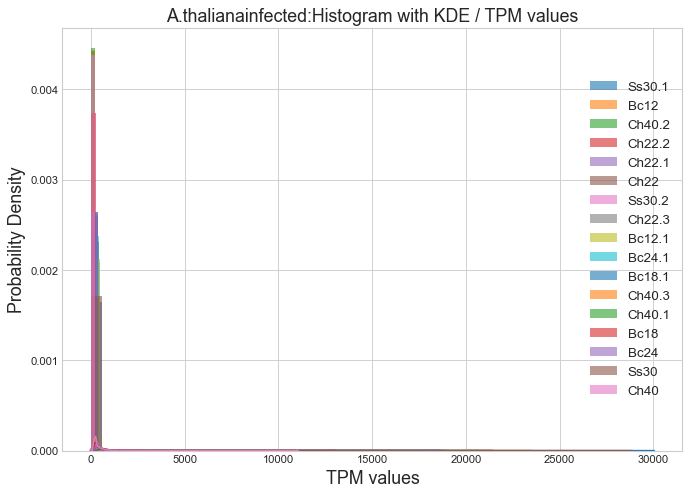

In [13]:
df_KDE(df_plot, sample_lst, general_titles, 'TPM values')

Preparing series for all samples
Preparing series for all atypical


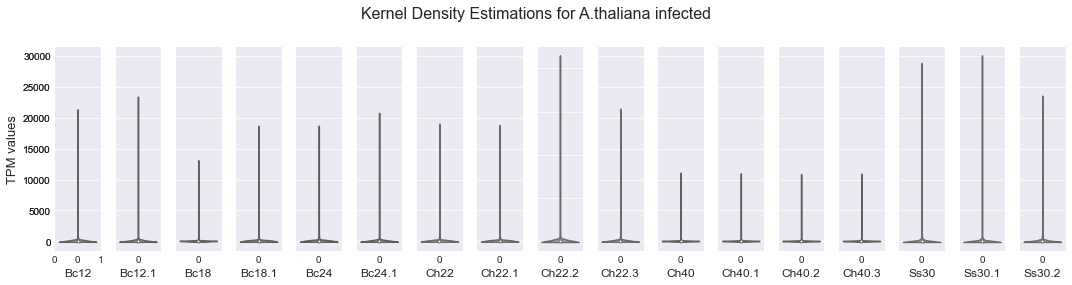

In [14]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM values')

### TPM standarization: Let's to assess the number of zeros by sample after the normalization  

Letś see it is more convinient to use a well tested expression filtering scheme as  "GTEx's scheme" (Genes were selected based on expression **thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples)*** <br>
For my own analysis, deleting genes without counts in 70% of the data set seems convenient, because these genes are underrepresented. And the hight expr.levels underrepresented need also be removed. <br>
***Let's start with the low values.***

In [15]:
## Check number of zeros by sample
sr_ceros = df_expr.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [16]:
df_ceros[0:5]

,0
Genes,0
Ss30.1,7185
Bc12,4103
Ch40.2,3702
Ch22.2,3770


In [17]:
# Firts, we check the number of zeros across all samples gotten after the normalization 
s_zeros=(df_expr == 0.000).astype(int).sum(axis=1)

## Added a column to df1 with the counter of zeros
df_expr['zero-counter'] = s_zeros
df_expr.head(20)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,0
5,AT1G01070,0.462,6.107,8.427,3.699,7.641,5.548,0.304,3.392,5.994,5.007,4.770,7.977,6.404,6.367,5.906,1.164,7.244,0
6,AT1G01080,11.914,144.631,21.067,37.261,36.068,37.530,10.900,37.625,135.253,43.998,81.681,17.262,23.327,73.053,50.597,10.149,22.144,0
7,AT1G01090,63.554,127.040,76.441,95.302,93.725,100.901,99.239,103.715,121.394,134.278,164.026,69.568,78.312,158.616,146.591,66.921,68.547,0
8,AT1G01100,32.061,156.522,156.710,278.338,223.684,224.265,55.848,267.065,146.087,170.378,166.832,156.491,217.317,240.706,190.794,40.460,232.356,0
9,AT1G01110,0.000,0.602,0.154,0.309,0.152,0.155,0.089,0.235,0.877,4.394,0.310,0.077,0.083,0.349,4.516,0.000,0.000,3


### TPM standarization 
Remove the genes with zeros thru all samples

In [18]:
# Here, we look for genes with zeros up to 70% presense on the samples
# Infected: 17 samples * 0.70 = 11.9; Thus, we are looking for genes with equal or more than 12 zeros.
# Healthy: 8 samples * 0.70 = 5.6; Thus, we are looking for genes with equal or more than 6 zeros.
if general_titles == 'healthy':
    is_zero = (df_expr['zero-counter']>=6)     
else:
    is_zero = (df_expr['zero-counter']>=12)     

df_zero = df_expr[is_zero]
print(len(df_zero))
df_zero.head(7)
## Send the new df to all_log2_counter_cero.csv 
#df_zero.to_csv('', sep='\t', index=False)

3081


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
13,AT1G01150,0.000,0.0,0.0,0.0,0.0,0.0,0.213,0.0,0.0,0.047,0.0,0.0,0.0,0.0,0.141,0.000,0.000,14
26,AT1G01280,0.000,0.0,0.0,0.0,0.0,0.0,0.124,0.0,0.0,0.608,0.0,0.0,0.0,0.0,0.493,0.000,0.000,14
29,AT1G01305,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.416,0.000,0.000,16
39,AT1G01400,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.090,0.0,0.0,0.0,0.0,0.089,0.000,0.000,15
45,AT1G01460,1.458,0.0,0.0,0.0,0.0,0.0,0.884,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.251,0.091,13
97,AT1G01980,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.000,0.158,0.000,16
106,AT1G02065,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,10.191,0.0,0.0,0.0,0.0,11.677,0.000,0.000,15


In [19]:
# call the custom df_drop_idx_list function to delete the list of indexes to be deleted
print(len(df_expr))
df1 = df_drop_idx_list(df_zero,df_expr)
print(len(df1))
df1.head(5)

24239
21158


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,0
4,AT1G01060,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855,0


In [20]:
df1.isin([0]).sum()

Genes               0
Ss30.1           4344
Bc12             1403
Ch40.2           1048
Ch22.2            976
Ch22.1            933
Ch22              984
Ss30.2           3415
Ch22.3            985
Bc12.1           1296
Bc24.1            567
Bc18.1           1450
Ch40.3           1046
Ch40.1            918
Bc18             1339
Bc24              533
Ss30             4567
Ch40              857
zero-counter    14423
dtype: int64

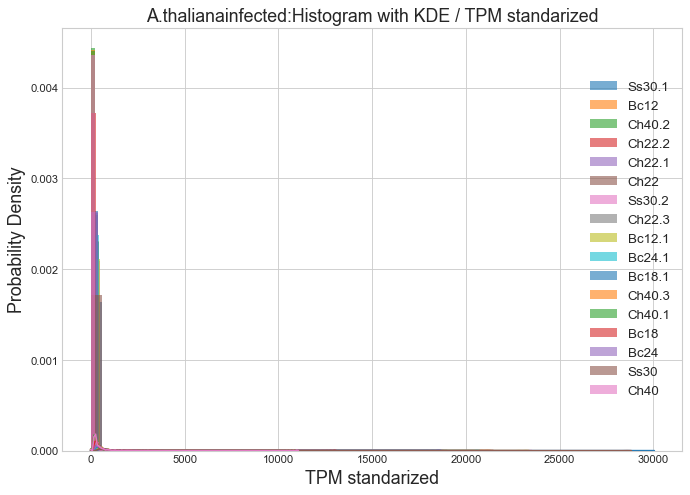

In [21]:
# chk the distribution
df_plot=df1.drop(['Genes','zero-counter'], axis=1)   #, inplace = True
## Get sample list names
df_KDE(df_plot, sample_lst, general_titles , 'TPM standarized')

Preparing series for all samples
Preparing series for all atypical


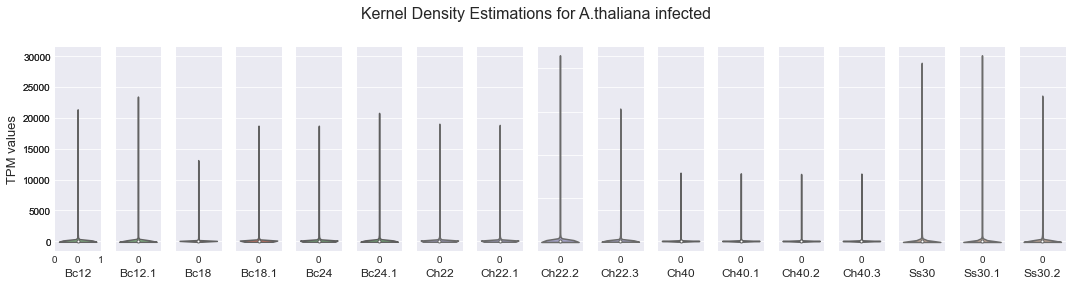

In [25]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM values')

In [21]:
df1.describe()

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
count,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000,21158.000
mean,47.252,47.243,47.256,47.258,47.259,47.260,47.255,47.260,47.249,47.189,47.256,47.256,47.257,47.259,47.181,47.253,47.258,1.260
std,395.088,276.683,224.509,245.634,246.387,246.707,342.046,245.078,294.429,246.867,270.965,224.934,214.496,253.736,243.275,382.682,214.385,2.516
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.142,2.141,1.936,3.059,2.777,2.773,0.266,3.059,2.028,3.002,1.923,1.915,2.424,1.880,3.268,0.139,2.412,0.000
50%,1.644,10.794,9.509,14.036,13.289,13.216,2.516,14.119,10.456,12.170,10.592,9.570,11.170,10.884,12.684,1.753,11.140,0.000
75%,11.828,30.529,30.899,37.200,36.007,35.994,15.164,37.242,29.464,34.116,30.001,30.967,33.400,31.310,34.472,12.164,33.449,1.000
max,30046.794,21314.028,10852.459,21455.952,18793.409,18983.608,23508.034,21435.898,23373.501,20742.000,18660.458,10902.914,10959.750,13089.181,18666.461,28819.222,11056.693,11.000


In [24]:
maxValues = df_plot.max()
print(maxValues)
minValues = df_plot.min()
print(minValues)

Ss30.1    30046.794
Bc12      21314.028
Ch40.2    10852.459
Ch22.2    21455.952
Ch22.1    18793.409
Ch22      18983.608
Ss30.2    23508.034
Ch22.3    21435.898
Bc12.1    23373.501
Bc24.1    20742.000
Bc18.1    18660.458
Ch40.3    10902.914
Ch40.1    10959.750
Bc18      13089.181
Bc24      18666.461
Ss30      28819.222
Ch40      11056.693
dtype: float64
Ss30.1    0.0
Bc12      0.0
Ch40.2    0.0
Ch22.2    0.0
Ch22.1    0.0
Ch22      0.0
Ss30.2    0.0
Ch22.3    0.0
Bc12.1    0.0
Bc24.1    0.0
Bc18.1    0.0
Ch40.3    0.0
Ch40.1    0.0
Bc18      0.0
Bc24      0.0
Ss30      0.0
Ch40      0.0
dtype: float64


In [25]:
# find the maximum values of each row
maxValues = df1.max(axis = 1)
print(maxValues)

0         20.073
1          7.629
2         25.290
3        137.089
4        624.446
          ...   
24234      5.944
24235     47.993
24236    131.528
24237      9.000
24238      7.348
Length: 21158, dtype: float64


<AxesSubplot:>

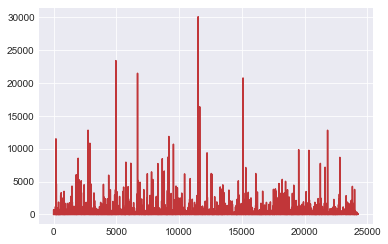

In [26]:
maxValues.plot()

### Now, let's to check low & hight extreme values (TPM)
Filtering "scheme" (Genes were selected based on expression thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples)<br>

CV obviously depends very strongly on mean expression such that lowly expressed genes are going to tend to have much higher CV. Therefore, we cannot trust the CV of very lowly expressed genes, and so these should be filtered out of your analysis. If you want a well tested expression filtering scheme, you could use GTEx's scheme (Genes were selected based on expression thresholds of >0.1 TPM in at least 20% of samples and ≥6 reads in at least 20% of samples).

In [22]:
df1.iloc[1:5, 1:18]

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
1,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940
3,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041
4,0.224,35.317,27.628,21.414,9.856,9.315,0.065,20.321,37.872,3.957,624.446,29.229,28.791,580.595,2.944,0.167,31.855


In [23]:
len(df1)

21158

**chuck for cut LOW VALUES**

In [24]:
## Filtering across samples
from collections import defaultdict
dict_cut = defaultdict(list)

size_original= len(df1)
print("current matriz size:",size_original)

try:
    ## set a threshold
    cut_value = 0.1    
    print("Threshold is set on:",cut_value)
    b_first=True

    for sample in sample_lst:   #parse by samples
        if b_first:
            df_cut = filter_low_vals_df(df1, (sample, cut_value))
            b_first = False       
        else:
            df_cut = filter_low_vals_df(df_cut, (sample, cut_value))
        
        size_new = len(df_cut)
        size = size_original - size_new
        print(sample+' removed:',str(size))
        dict_cut['ID'].append(sample)    
        dict_cut['genes_cut'].append(size)
except:
    print("Error")

df_cut_stats = pd.DataFrame(dict_cut)
print("new matrix size:",len(df_cut))
df_cut.head(5)

current matriz size: 21158
Threshold is set on: 0.1
Ss30.1 removed: 4834
Bc12 removed: 5638
Ch40.2 removed: 5820
Ch22.2 removed: 5913
Ch22.1 removed: 5955
Ch22 removed: 5981
Ss30.2 removed: 6416
Ch22.3 removed: 6431
Bc12.1 removed: 6529
Bc24.1 removed: 6553
Bc18.1 removed: 6609
Ch40.3 removed: 6626
Ch40.1 removed: 6638
Bc18 removed: 6679
Bc24 removed: 6687
Ss30 removed: 7238
Ch40 removed: 7242
new matrix size: 13916


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,0
5,AT1G01070,0.462,6.107,8.427,3.699,7.641,5.548,0.304,3.392,5.994,5.007,4.770,7.977,6.404,6.367,5.906,1.164,7.244,0


In [25]:
df1 = df_cut
df1.describe()

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
count,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.000,13916.0
mean,65.691,65.336,68.401,67.692,68.314,68.297,66.586,67.692,65.561,67.609,67.333,68.394,68.380,67.939,67.355,66.164,68.369,0.0
std,473.469,336.233,273.046,298.598,300.651,301.089,410.917,297.914,358.351,301.255,331.101,273.586,261.074,309.833,296.840,459.862,260.922,0.0
min,0.100,0.102,0.109,0.105,0.111,0.105,0.100,0.128,0.104,0.128,0.100,0.114,0.125,0.107,0.117,0.100,0.104,0.0
25%,1.341,7.920,8.100,11.848,11.376,11.259,2.147,11.808,7.592,9.908,8.275,8.138,9.369,8.765,10.190,1.458,9.300,0.0
50%,5.339,18.068,19.258,25.059,24.239,24.241,7.555,25.200,17.538,22.448,18.829,19.189,21.414,20.031,22.855,5.716,21.465,0.0
75%,23.105,42.928,48.241,54.393,53.122,53.229,28.900,54.327,41.343,51.297,44.031,48.273,51.871,46.371,51.071,24.227,51.527,0.0
max,30046.794,21314.028,10852.459,21455.952,18793.409,18983.608,23508.034,21435.898,23373.501,20742.000,18660.458,10902.914,10959.750,13089.181,18666.461,28819.222,11056.693,0.0


In [32]:
df_stat = df1.describe().T
lst_stat = df_stat['min'].to_list()
lst_stat.sort()
(lst_stat)

[0.0,
 0.10023681906316463,
 0.10024416964555656,
 0.10032144195803153,
 0.10034878021145456,
 0.10192676959567416,
 0.1039471733346534,
 0.10396701927919227,
 0.10491607553674988,
 0.10492375850980563,
 0.10693144747592308,
 0.10903733580136582,
 0.11113532834359544,
 0.11437412003066127,
 0.11740942566580878,
 0.1248127849395297,
 0.12795858146944689,
 0.12849710592859234]

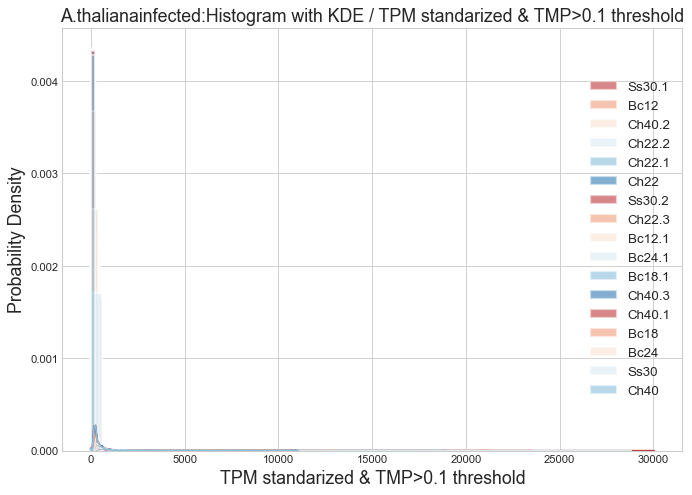

In [26]:
# chk the distribution
df_plot=df1.drop(['Genes','zero-counter'], axis=1)   #, inplace = True
## Get sample list names
df_KDE(df_plot, sample_lst, general_titles , 'TPM standarized & TMP>0.1 threshold')

Preparing series for all samples
Preparing series for all atypical


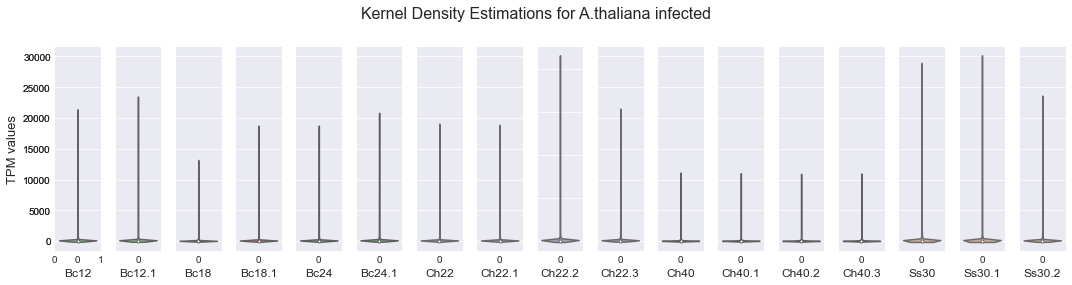

In [34]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM values')

**chuck for cut HIGH VALUES**

In [27]:
## Filtering across samples
size_original= len(df1)
print("current matriz size:",size_original)

try:
    ## set a threshold
    cut_value = 1000  
    print("Threshold is set on:",cut_value)
    b_first=True

    for sample in sample_lst:   #parse all the samples
        if b_first:
            df_cut = filter_high_vals_df(df1, (sample, cut_value))
            b_first = False       
        else:
            df_cut = filter_high_vals_df(df_cut, (sample, cut_value))
        
        size_new = len(df_cut)
        size = size_original - size_new
        print(sample+' removed:',str(size))
        dict_cut['ID'].append(sample)    
        dict_cut['genes_cut'].append(size)
except:
    print("Error")

df_cut_stats = pd.DataFrame(dict_cut)
print("new matrix size:",len(df_cut))
df_cut.head(5)

current matriz size: 13916
Threshold is set on: 1000
Ss30.1 removed: 140
Bc12 removed: 244
Ch40.2 removed: 285
Ch22.2 removed: 302
Ch22.1 removed: 308
Ch22 removed: 308
Ss30.2 removed: 314
Ch22.3 removed: 314
Bc12.1 removed: 317
Bc24.1 removed: 329
Bc18.1 removed: 344
Ch40.3 removed: 344
Ch40.1 removed: 344
Bc18 removed: 347
Bc24 removed: 347
Ss30 removed: 354
Ch40 removed: 354
new matrix size: 13562


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0
3,AT1G01050,3.196,131.336,34.788,57.632,58.287,55.734,7.773,63.753,137.089,59.382,96.888,33.258,45.279,88.730,68.733,4.967,41.041,0
5,AT1G01070,0.462,6.107,8.427,3.699,7.641,5.548,0.304,3.392,5.994,5.007,4.770,7.977,6.404,6.367,5.906,1.164,7.244,0


In [28]:
## save the new matrix filtered of low and extreme high levels
df1 = df_cut
df1.drop(['zero-counter'],axis=1, inplace = True)
#df1.to_csv('all_'+general_titles+'_TPM_filtered.csv', sep='\t', index=False)

In [29]:
## save the stats of new matrix filtered
df_stat=df1.describe().T
#df_stat.to_csv("../statistics/all_TPM_filtered_"+general_titles+"_stats.csv", index=True, header=True)

In [30]:
df_stat

,count,mean,std,min,25%,50%,75%,max
Ss30.1,13562.0,32.369,89.392,0.100,1.294,5.077,21.349,988.677
Bc12,13562.0,41.863,76.847,0.102,7.860,17.709,40.690,923.342
Ch40.2,13562.0,45.974,84.224,0.109,7.900,18.554,45.245,991.061
Ch22.2,13562.0,47.925,75.558,0.105,11.611,24.416,50.960,982.779
Ch22.1,13562.0,47.014,74.095,0.111,11.137,23.474,49.973,983.020
Ch22,13562.0,47.029,74.261,0.105,11.041,23.556,49.743,982.129
Ss30.2,13562.0,35.268,87.957,0.100,2.096,7.247,26.496,975.282
Ch22.3,13562.0,47.951,75.464,0.128,11.554,24.419,51.027,956.104
Bc12.1,13562.0,40.946,76.385,0.117,7.524,17.189,39.364,948.983
Bc24.1,13562.0,44.513,71.908,0.128,9.632,21.518,47.548,972.867


In [31]:
lst_stat = df_stat['max'].to_list()
lst_stat.sort()
lst_stat[1:5]

[923.3422418691252, 940.9126512198164, 948.9825302272676, 956.1037403386256]

In [31]:
## save the stats of the genes removed for building the new matrix
df_cut_stats = pd.DataFrame(dict_cut)
#df_cut_stats.to_csv("../statistics/all_TPM_removed_"+general_titles+".csv", index=False, header=True)
## File structure:   
##      first iteration is the number of genes with the lowest values removed 
##      second iteration is the number of genes with the highest values removed 

### Let's check some visualizations

In [32]:
df1.head(3)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


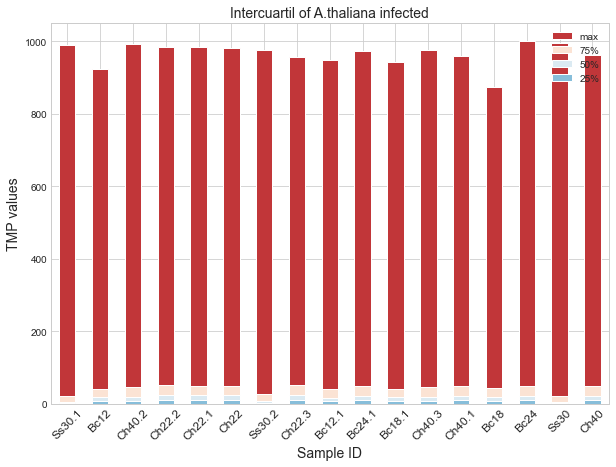

In [33]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'TMP values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


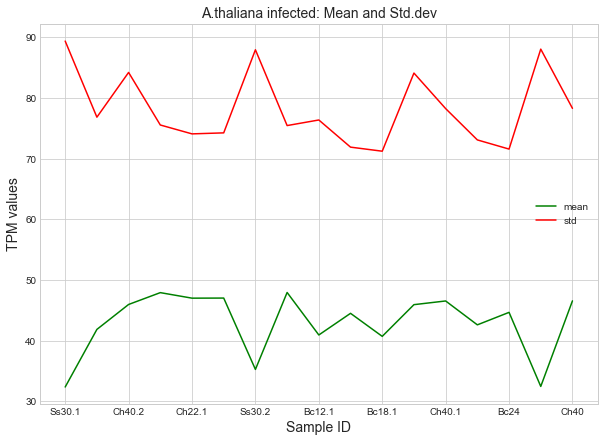

In [34]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','TPM values')

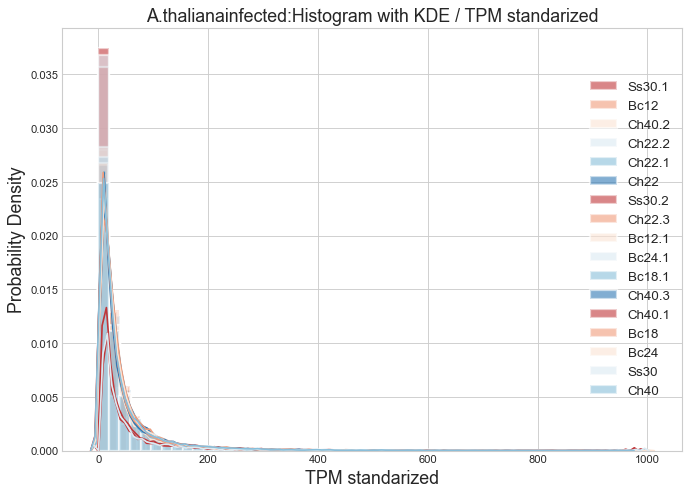

In [35]:
# chk the distribution
df_plot=df1.drop(['Genes'], axis=1)   #, inplace = True
df_KDE(df_plot, sample_lst, general_titles, 'TPM standarized')

Preparing series for all samples
Preparing series for all atypical


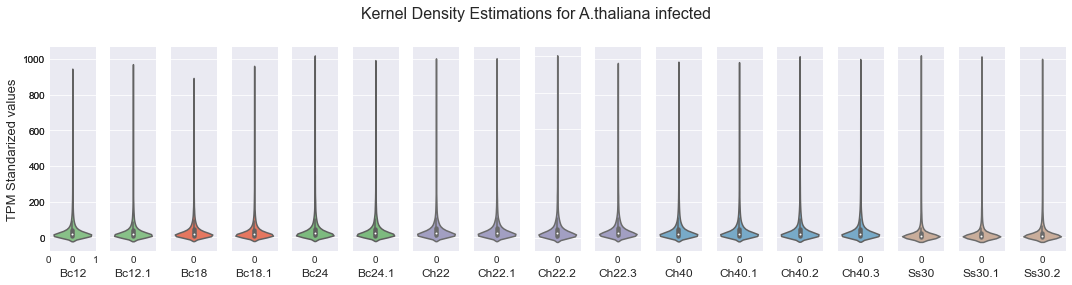

In [53]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_plot, general_titles, 0, False, 'TPM Standarized values')

## Let's to apply log2 to reduce the scale effect
Exist the possibility to have to apply log2 to reduce the scale effect. Take in account that the lowest TPM values will turn negative, but they are in fact positive. <br>
Will turn to a normal distribution to apply a log transformation? 
https://en.wikipedia.org/wiki/Log-normal_distribution

In [36]:
print(len(df_cut))
df1.head(2)

13562


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248


In [37]:
df_log2 = np.log2(df1.iloc[:, 1:19])
df_log2.head(5)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,2.385,3.451,3.609,4.195,3.973,4.131,2.120,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,2.313,3.755
1,2.810,-0.402,0.690,0.695,0.353,0.373,2.931,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,2.320,1.169
2,0.787,4.247,3.858,4.616,4.382,4.303,1.490,4.660,4.277,3.796,4.377,3.815,3.918,4.403,3.751,1.326,3.995
3,1.676,7.037,5.121,5.849,5.865,5.800,2.959,5.994,7.099,5.892,6.598,5.056,5.501,6.471,6.103,2.312,5.359
5,-1.113,2.611,3.075,1.887,2.934,2.472,-1.720,1.762,2.584,2.324,2.254,2.996,2.679,2.671,2.562,0.219,2.857


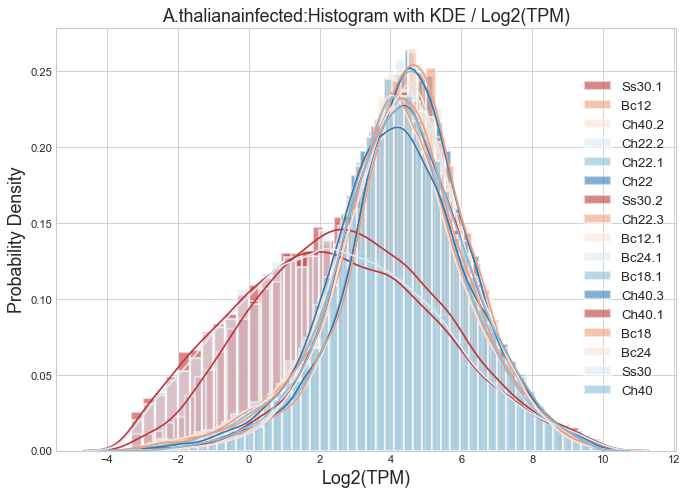

In [38]:
# chk the distribution
df_KDE(df_log2, sample_lst, general_titles, 'Log2(TPM)')

In [39]:
## concat the gene names
df_log2 = pd.concat([df1['Genes'], df_log2], axis=1, join="inner")

In [40]:
df_log2.head(2)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,2.385,3.451,3.609,4.195,3.973,4.131,2.120,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,2.313,3.755
1,AT1G01030,2.810,-0.402,0.690,0.695,0.353,0.373,2.931,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,2.320,1.169


In [45]:
## save the new matrix filtered of low and extreme high levels
#df_log2.to_csv('all_'+general_titles+'_Log2TPM_filtered.csv', sep='\t', index=False)

Preparing series for all samples
Preparing series for all atypical


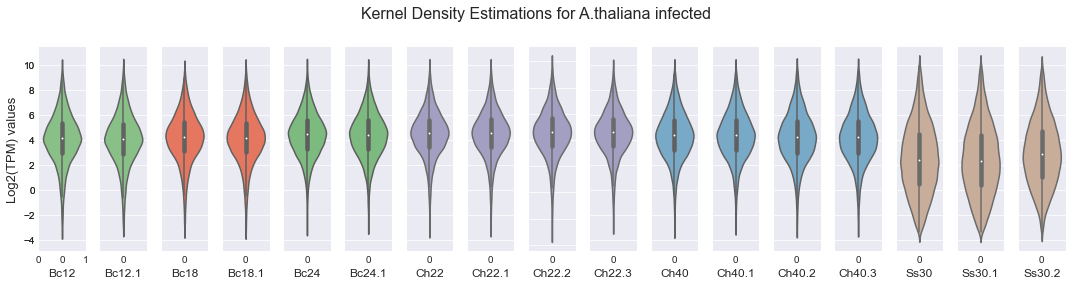

In [59]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 0, False, 'Log2(TPM) values')

**A bit of stats**

In [41]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
print("Stats for A.thaliana Log2(TPM) dataset")
df_stat
#df_stat.to_csv("../statistics/all_Log2TPM_filtered_"+general_titles+"_stats.csv", index=True, header=True)

Stats for A.thaliana Log2(TPM) dataset


,count,mean,std,min,25%,50%,75%,max
Ss30.1,13562.0,2.453,2.785,-3.318,0.372,2.344,4.416,9.949
Bc12,13562.0,4.102,2.009,-3.294,2.975,4.146,5.347,9.851
Ch40.2,13562.0,4.229,1.969,-3.197,2.982,4.214,5.500,9.953
Ch22.2,13562.0,4.559,1.784,-3.253,3.537,4.610,5.671,9.941
Ch22.1,13562.0,4.517,1.793,-3.170,3.477,4.553,5.643,9.941
Ch22,13562.0,4.515,1.795,-3.253,3.465,4.558,5.636,9.940
Ss30.2,13562.0,2.938,2.572,-3.317,1.067,2.857,4.728,9.930
Ch22.3,13562.0,4.562,1.777,-2.960,3.530,4.610,5.673,9.901
Bc12.1,13562.0,4.050,2.022,-3.098,2.911,4.103,5.299,9.890
Bc24.1,13562.0,4.407,1.794,-2.966,3.268,4.427,5.571,9.926


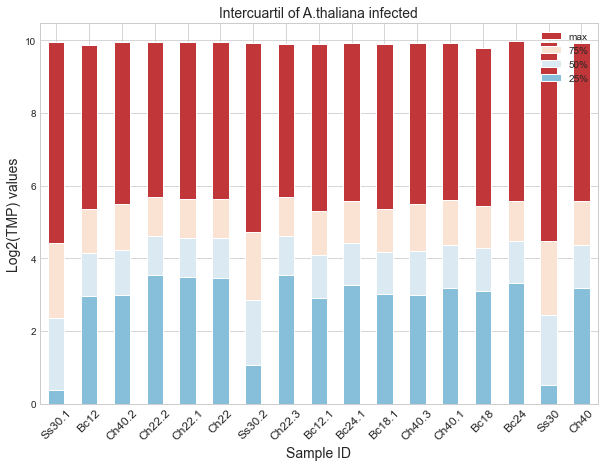

In [42]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'Log2(TMP) values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


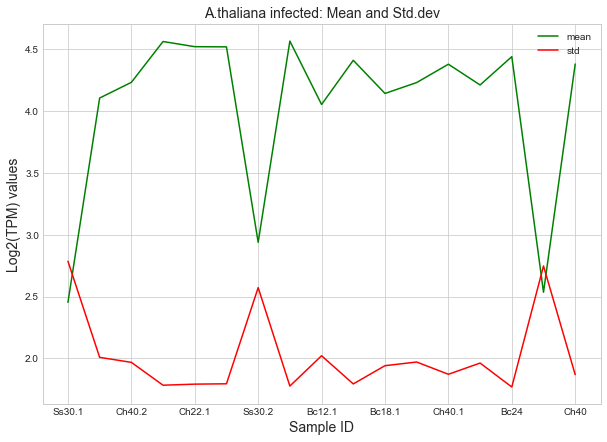

In [43]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','Log2(TPM) values')

In [44]:
lst_stat=df_stat['std'].to_list()
lst_stat.sort()
lst_stat

[1.7695755665140536,
 1.7772387715844034,
 1.78402821188828,
 1.7927129343968111,
 1.794405304914898,
 1.7954813572006685,
 1.8693143717238712,
 1.8723141612255625,
 1.9416990119269226,
 1.9628419474629835,
 1.96850945657292,
 1.9712441985278932,
 2.009130290842694,
 2.021812112222324,
 2.5717191622720743,
 2.746554805820244,
 2.7849927117925817]

***KDE samples SS30*** <br>
https://stackabuse.com/seaborn-violin-plot-tutorial-and-examples/

In [76]:
violin_plot

<function __main__.violin_plot(dfx, ds, atypical, b_swarm, ylab)>

Preparing series for all samples
Preparing series for all atypical


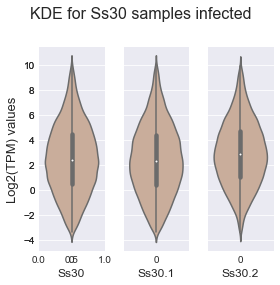

In [77]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 2, False, 'Log2(TPM) values')

**Take an overview for central values and distributions for the entire dataset**

In [78]:
dfx = df_log2
dfx

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,2.385,3.451,3.609,4.195,3.973,4.131,2.120,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,2.313,3.755
1,AT1G01030,2.810,-0.402,0.690,0.695,0.353,0.373,2.931,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,2.320,1.169
2,AT1G01040,0.787,4.247,3.858,4.616,4.382,4.303,1.490,4.660,4.277,3.796,4.377,3.815,3.918,4.403,3.751,1.326,3.995
3,AT1G01050,1.676,7.037,5.121,5.849,5.865,5.800,2.959,5.994,7.099,5.892,6.598,5.056,5.501,6.471,6.103,2.312,5.359
5,AT1G01070,-1.113,2.611,3.075,1.887,2.934,2.472,-1.720,1.762,2.584,2.324,2.254,2.996,2.679,2.671,2.562,0.219,2.857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24222,ATMG01130,2.097,0.760,4.285,3.978,4.006,3.579,2.490,3.309,-1.546,1.476,1.709,4.470,4.426,0.710,0.728,2.996,4.738
24226,ATMG01220,2.420,-0.332,4.153,2.836,2.708,3.552,1.551,3.217,1.532,0.648,2.033,4.109,4.169,1.204,-0.364,1.168,4.078
24233,ATMG01330,-0.747,0.823,1.856,2.031,1.841,1.446,2.232,0.880,1.195,0.218,0.450,0.854,1.958,0.452,0.884,1.416,2.657
24235,ATMG01360,2.764,1.666,5.470,4.174,4.296,4.045,2.339,4.036,1.151,-0.242,1.406,5.585,4.990,1.452,0.088,2.326,4.978


### More stats for the atypical distributions: Ss30 
Let's remove them and analize the effect

In [79]:
df_log2.head(2)
df_log2.drop(['Ss30.1','Ss30.2','Ss30'], axis='columns', inplace=True)

In [96]:
print(len(df_log2.columns))
df_log2.head(2)

15


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ch40
0,AT1G01020,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,3.755
1,AT1G01030,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,1.169


**A bit of stats**

In [97]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
print("Stats for A.thaliana Log2(TPM) dataset / No Ss30 samples")
df_stat

Stats for A.thaliana Log2(TPM) dataset / No Ss30 samples


,count,mean,std,min,25%,50%,75%,max
Bc12,13562.0,4.102,2.009,-3.294,2.975,4.146,5.347,9.851
Ch40.2,13562.0,4.229,1.969,-3.197,2.982,4.214,5.500,9.953
Ch22.2,13562.0,4.559,1.784,-3.253,3.537,4.610,5.671,9.941
Ch22.1,13562.0,4.517,1.793,-3.170,3.477,4.553,5.643,9.941
Ch22,13562.0,4.515,1.795,-3.253,3.465,4.558,5.636,9.940
Ch22.3,13562.0,4.562,1.777,-2.960,3.530,4.610,5.673,9.901
Bc12.1,13562.0,4.050,2.022,-3.098,2.911,4.103,5.299,9.890
Bc24.1,13562.0,4.407,1.794,-2.966,3.268,4.427,5.571,9.926
Bc18.1,13562.0,4.139,1.942,-3.319,3.021,4.184,5.365,9.878
Ch40.3,13562.0,4.227,1.971,-3.128,2.983,4.212,5.498,9.930


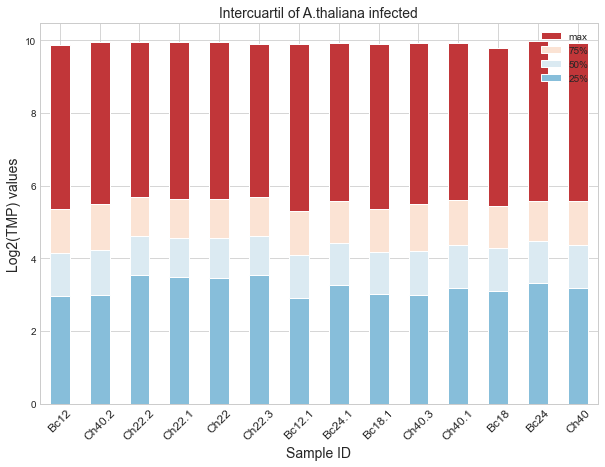

In [98]:
plot_intercuartile_bar(df_stat, "Intercuartil of A.thaliana " + general_titles, 'Log2(TMP) values' )

/home/cyntsc/Proyectos/tesis-code/jn_tesis_env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


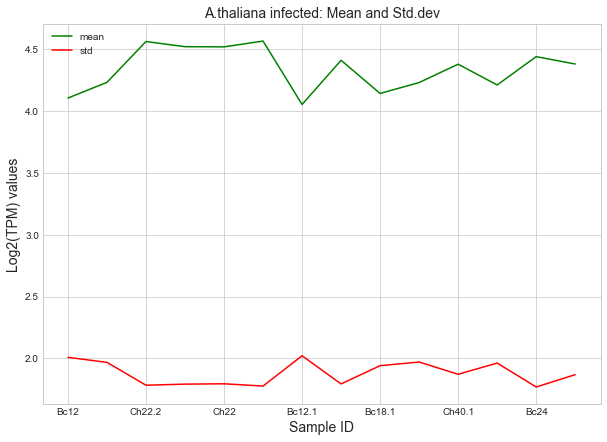

In [99]:
plot_mean_sdev_line(df_stat, 'A.thaliana '+ general_titles +': Mean and Std.dev','Log2(TPM) values')

In [100]:
lst_stat=df_stat['mean'].to_list()
lst_stat.sort()
lst_stat

[4.050315809822821,
 4.102172213802607,
 4.139290894770804,
 4.207662076561451,
 4.227258859317721,
 4.228915758631321,
 4.375358060339952,
 4.37684700645904,
 4.406916454509298,
 4.4363008321639,
 4.515326304053121,
 4.516807120393854,
 4.558589746717621,
 4.562084128310283]

***KDE without the Ss30 samples***

In [101]:
df1.columns.to_list()

['Genes',
 'Ss30.1',
 'Bc12',
 'Ch40.2',
 'Ch22.2',
 'Ch22.1',
 'Ch22',
 'Ss30.2',
 'Ch22.3',
 'Bc12.1',
 'Bc24.1',
 'Bc18.1',
 'Ch40.3',
 'Ch40.1',
 'Bc18',
 'Bc24',
 'Ss30',
 'Ch40']

In [102]:
sample_lst=df1.columns.to_list()
sample_lst.remove('Genes')
sample_lst.remove('Ss30.1')
sample_lst.remove('Ss30.2')
sample_lst.remove('Ss30')
sample_lst

['Bc12',
 'Ch40.2',
 'Ch22.2',
 'Ch22.1',
 'Ch22',
 'Ch22.3',
 'Bc12.1',
 'Bc24.1',
 'Bc18.1',
 'Ch40.3',
 'Ch40.1',
 'Bc18',
 'Bc24',
 'Ch40']

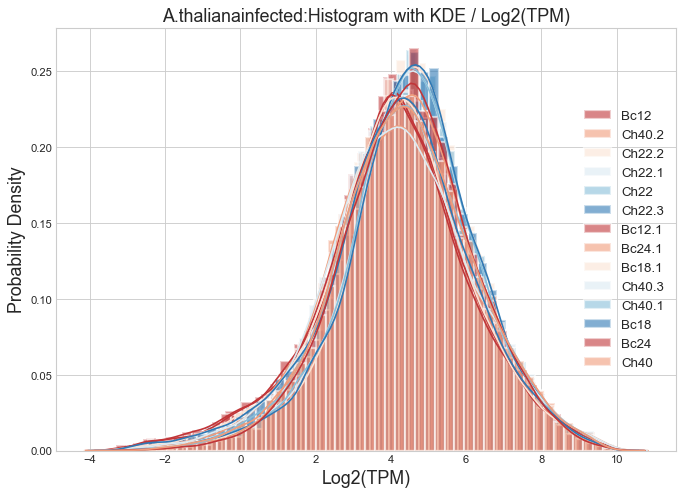

In [104]:
# chk the distribution
df_KDE(df_log2, sample_lst, general_titles, 'Log2(TPM)')

***Violin plot with KDE without Ss30***

Preparing series for all samples


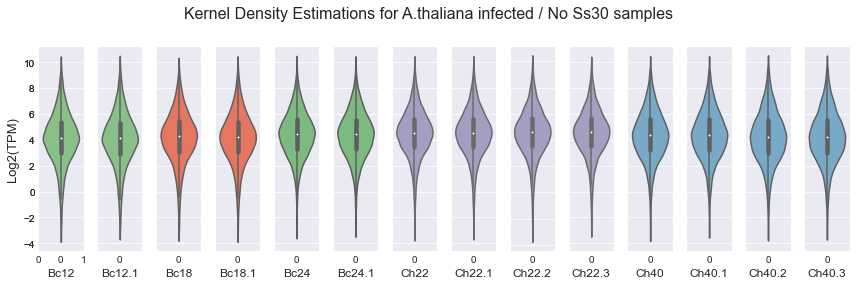

In [108]:
# atypical; #         0 = all samples / 1 = all with out atypical samples / 2 = only atypical    
#violin_series_preparation(df_plot, general_titles, 0)
violin_plot(df_log2, general_titles, 1, False, 'Log2(TPM)')

In [109]:
## save the new matrix filtered of low and extreme high levels
#df_log2.to_csv('all_'+general_titles+'_Log2TPM_No_Ss30.csv', sep='\t', index=False)

In [74]:
## save the stats of new matrix filtered
df_stat=df_log2.describe().T
#df_stat.to_csv("../statistics/all_Log2TPM_No_Ss30_"+general_titles+"_stats.csv", index=True, header=True)

### To finish, let's to merge A.thaliana healthy and infected in one matrix (iiner operation)

In [111]:
df_healty=pd.read_csv("all_healthy_Log2TPM_filtered.csv", header=0, sep='\t', engine='python')
print(len(df_healty))
df_healty.head(5)
df_infected=pd.read_csv("all_infected_Log2TPM_No_Ss30.csv", sep='\t', engine='python')
print(len(df_infected))
df_infected.head(5)

17246
13562


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ch40
0,AT1G01020,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,3.379,3.711,3.654,2.914,3.755
1,AT1G01030,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,0.826,0.277,1.423,2.097,1.169
2,AT1G01040,4.247,3.858,4.616,4.382,4.303,4.660,4.277,3.796,4.377,3.815,3.918,4.403,3.751,3.995
3,AT1G01050,7.037,5.121,5.849,5.865,5.800,5.994,7.099,5.892,6.598,5.056,5.501,6.471,6.103,5.359
4,AT1G01070,2.611,3.075,1.887,2.934,2.472,1.762,2.584,2.324,2.254,2.996,2.679,2.671,2.562,2.857


In [112]:
#result = pd.merge(df_infected, df_healty, on='Gene')
result = df_infected.merge(df_healty,on=['Genes'],how='inner')

In [113]:
print(len(result))
result.head(5)

13228


,Genes,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,...,Bc24,Ch40,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,AT1G01020,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,...,2.914,3.755,3.084,2.831,3.312,3.012,2.857,3.095,3.567,3.210
1,AT1G01030,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,...,2.097,1.169,0.657,0.829,0.959,0.544,0.880,1.274,0.668,-0.098
2,AT1G01040,4.247,3.858,4.616,4.382,4.303,4.660,4.277,3.796,4.377,...,3.751,3.995,4.835,4.656,4.452,4.402,4.154,3.780,4.562,3.912
3,AT1G01050,7.037,5.121,5.849,5.865,5.800,5.994,7.099,5.892,6.598,...,6.103,5.359,6.656,6.742,6.731,6.833,6.871,5.680,6.803,5.891
4,AT1G01070,2.611,3.075,1.887,2.934,2.472,1.762,2.584,2.324,2.254,...,2.562,2.857,0.742,2.034,1.773,3.391,3.153,2.326,1.652,3.609


In [114]:
## save the union matrix 
#result.to_csv('all_Log2TPM_inner.csv', sep='\t', index=False)

In [115]:
## save the stats of new union matrix
df_stat=result.describe().T
#df_stat.to_csv("../statistics/all_Log2TPM_inner_stats.csv", index=True, header=True)
df_stat

,count,mean,std,min,25%,50%,75%,max
Bc12,13228.0,4.176,1.901,-3.290,3.039,4.177,5.366,9.851
Ch40.2,13228.0,4.253,1.923,-3.197,3.011,4.225,5.496,9.953
Ch22.2,13228.0,4.611,1.712,-3.216,3.596,4.630,5.679,9.941
Ch22.1,13228.0,4.566,1.721,-2.797,3.531,4.581,5.655,9.941
Ch22,13228.0,4.565,1.725,-2.968,3.516,4.582,5.643,9.940
Ch22.3,13228.0,4.615,1.704,-2.465,3.590,4.635,5.680,9.901
Bc12.1,13228.0,4.128,1.906,-2.756,2.986,4.136,5.316,9.890
Bc24.1,13228.0,4.435,1.746,-2.966,3.315,4.452,5.573,9.926
Bc18.1,13228.0,4.203,1.852,-3.319,3.089,4.219,5.382,9.564
Ch40.3,13228.0,4.252,1.927,-3.128,3.023,4.221,5.491,9.930


In [116]:
# chk the distribution
sample_lst = result.columns.to_list()
sample_lst.remove('Genes')
sample_lst
df_plot = result.drop(['Genes'], axis='columns')
df_plot.head(2)
#df_KDE(df_log2, sample_lst, '/ Log2(TPM) normalization', 'Log2(TPM)')

,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,...,Bc24,Ch40,healthy30.1,healthy30,healthy12,healthy18.1,healthy18,healthy24.1,healthy12.1,healthy24
0,3.451,3.609,4.195,3.973,4.131,4.327,3.371,2.835,3.583,3.379,...,2.914,3.755,3.084,2.831,3.312,3.012,2.857,3.095,3.567,3.210
1,-0.402,0.690,0.695,0.353,0.373,0.200,1.029,2.291,1.626,0.826,...,2.097,1.169,0.657,0.829,0.959,0.544,0.880,1.274,0.668,-0.098


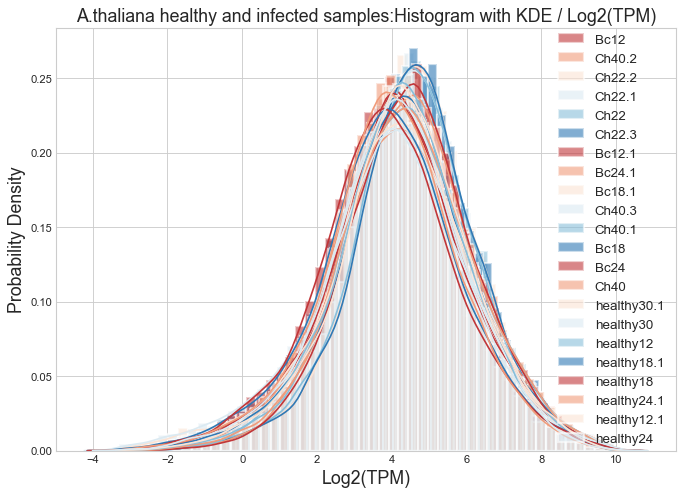

In [117]:
df_KDE(df_plot, sample_lst, ' healthy and infected samples', 'Log2(TPM)')